In [42]:
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime

aapl = pdr.get_data_yahoo('AAPL', start=datetime(2006, 1, 1), end=datetime(2020, 1, 1))

In [2]:
aapl

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,2.669643,2.580357,2.585000,2.669643,807234400.0,2.302969
2006-01-04,2.713571,2.660714,2.683214,2.677500,619603600.0,2.309747
2006-01-05,2.675000,2.633929,2.672500,2.656429,449422400.0,2.291571
2006-01-06,2.739286,2.662500,2.687500,2.725000,704457600.0,2.350724
2006-01-09,2.757143,2.705000,2.740357,2.716071,675040800.0,2.343021
...,...,...,...,...,...,...
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,70.459007
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.856941
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.829674


In [26]:
daily_close = aapl[["Adj Close"]]
daily_pct_change = daily_close.pct_change()
daily_pct_change.fillna(0,inplace=True)

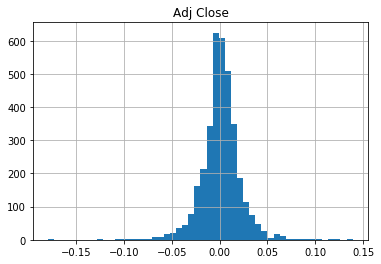

In [29]:
import matplotlib.pyplot as plt

daily_pct_change.hist(bins=50)
plt.show()

In [30]:
cum_daily_return = (1 + daily_pct_change).cumprod()

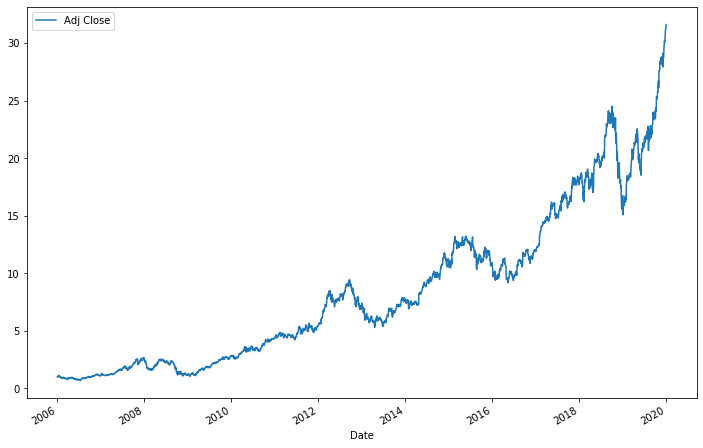

In [32]:
cum_daily_return.plot(figsize=(12,8))
plt.show()

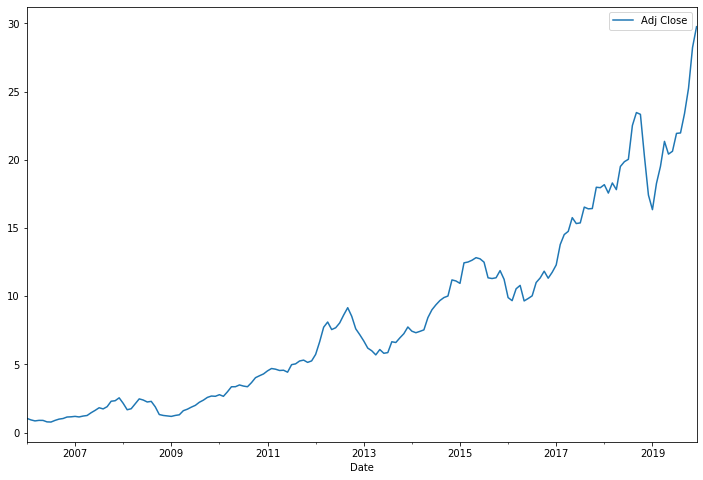

In [39]:
cum_monthly_return = cum_daily_return.resample("M").mean()

cum_monthly_return.plot(figsize=(12,8))
plt.show()

In [48]:
start = datetime(2020,1,1)
end = datetime(2020,12,31)

d = get_ticker_data(['GOOG', 'AAPL'], start, end)

In [51]:
def get(tickers: List[str], startdate: datetime, enddate: datetime) -> pd.DataFrame:
  def data(ticker: str) -> pd.DataFrame:
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map (data, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

d = get(['GOOG', 'AAPL'], start, end)

In [54]:
a = d[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')

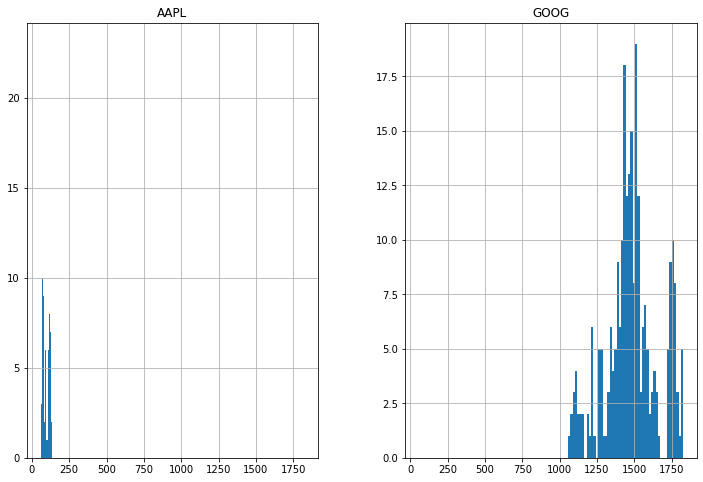

In [56]:
a.pct_change()

a.hist(bins=50, sharex=True, figsize=(12,8))
plt.show()

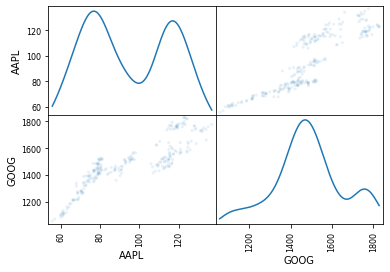

In [60]:
pd.plotting.scatter_matrix(a, diagonal='kde', alpha=0.1)
plt.show()

In [62]:
# Moving Rolling Average

adj_close_px = aapl['Adj Close']
moving_avg = adj_close_px.rolling(window=48).mean()
print(moving_avg[-10:])

Date
2019-12-17    63.577220
2019-12-18    63.837156
2019-12-19    64.067030
2019-12-20    64.295660
2019-12-23    64.550668
2019-12-24    64.811961
2019-12-26    65.097693
2019-12-27    65.377039
2019-12-30    65.644159
2019-12-31    65.925109
Name: Adj Close, dtype: float64


In [67]:
import numpy as np

short_window = 40
long_window = 100

signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# moving avg
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)    

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)

            signal  short_mavg  long_mavg  positions
Date                                                
2006-01-03     0.0    2.669643   2.669643        NaN
2006-01-04     0.0    2.673571   2.673571        0.0
2006-01-05     0.0    2.667857   2.667857        0.0
2006-01-06     0.0    2.682143   2.682143        0.0
2006-01-09     0.0    2.688929   2.688929        0.0
...            ...         ...        ...        ...
2019-12-24     1.0   66.424250  59.401700        0.0
2019-12-26     1.0   66.715625  59.643125        0.0
2019-12-27     1.0   67.006500  59.875125        0.0
2019-12-30     1.0   67.273750  60.106325        0.0
2019-12-31     1.0   67.510187  60.331875        0.0

[3523 rows x 4 columns]


In [74]:
initial_capital = 10000

positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100 * signals["signal"]

portfolio = positions.multiply(aapl['Adj Close'], axis=0)

pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(aapl['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio[:400])

                  AAPL    holdings          cash         total   returns
Date                                                                    
2006-01-03    0.000000    0.000000  10000.000000  10000.000000       NaN
2006-01-04    0.000000    0.000000  10000.000000  10000.000000  0.000000
2006-01-05    0.000000    0.000000  10000.000000  10000.000000  0.000000
2006-01-06    0.000000    0.000000  10000.000000  10000.000000  0.000000
2006-01-09    0.000000    0.000000  10000.000000  10000.000000  0.000000
...                ...         ...           ...           ...       ...
2007-07-31  405.938864  405.938864   9789.328265  10195.267129 -0.002914
2007-08-01  415.921021  415.921021   9789.328265  10205.249286  0.000979
2007-08-02  420.511436  420.511436   9789.328265  10209.839702  0.000450
2007-08-03  406.216240  406.216240   9789.328265  10195.544505 -0.001400
2007-08-06  416.691113  416.691113   9789.328265  10206.019378  0.001027

[400 rows x 5 columns]


In [70]:
returns = portfolio['returns']

sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

print(sharpe_ratio)

0.8182953709716384


In [75]:
days = (aapl.index[-1] - aapl.index[0]).days

# Calculate the CAGR 
cagr = ((((aapl['Adj Close'][-1]) / aapl['Adj Close'][1])) ** (365.0/days)) - 1

# Print the CAGR
print(cagr)

0.2794804332186476
